<a href="https://colab.research.google.com/github/Rey1380/WavLM/blob/main/WavLM_base%2B_telephony.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# WavLM-base+ for speaker verification task on teleohony data

The main idea of this notebook comes from: https://huggingface.co/docs/transformers/model_doc/wavlm#transformers.WavLMForXVector
which it has been developed to meet our purpose
    

**WavLM Model with an XVector feature extraction head on top for tasks like Speaker Verification.**

WavLM was proposed in WavLM: Unified Speech Representation Learning with Labeled and Unlabeled Data by Chengyi Wang, Yu Wu, Yao Qian, Kenichi Kumatani, Shujie Liu, Furu Wei, Michael Zeng, Xuedong Huang.(https://arxiv.org/abs/2101.07597)

This model inherits from PreTrainedModel (https://huggingface.co/docs/transformers/v4.21.1/en/main_classes/model#transformers.PreTrainedModel). Check the superclass documentation for the generic methods the library implements for all its model (such as downloading or saving etc.).

This model is a PyTorch torch.nn.Module (https://pytorch.org/docs/stable/nn.html#torch.nn.Module) sub-class. Use it as a regular PyTorch Module and refer to the PyTorch documentation for all matter related to general usage and behavior.


### Prerequisites

In [ ]:
!pip install  transformers 
!pip install --quiet datasets
!pip install pycm==3.

In [ ]:
from transformers import Wav2Vec2FeatureExtractor, WavLMForXVector
import torch
import librosa
import IPython.display as ipd
import numpy as np

### Resample data to 8000 Hz (for telephony task)

Speech is a continuous signal and to be treated by computers, it first has to be discretized, which is usually called **sampling**. The sampling rate hereby plays an important role in that it defines how many data points of the speech signal are measured per second. Therefore, sampling with a higher sampling rate results in a better approximation of the *real* speech signal but also necessitates more values per second.

A pretrained checkpoint expects its input data to have been sampled more or less from the same distribution as the data it was trained on. The same speech signals sampled at two different rates have a very different distribution, *e.g.*, doubling the sampling rate results in data points being twice as long. Thus, 
before fine-tuning a pretrained checkpoint of an ASR model, it is crucial to verify that the sampling rate of the data that was used to pretrain the model matches the sampling rate of the dataset used to fine-tune the model.

using ffmpeg to downsample any data!

directories are localy you must change them with your own

In [ ]:
#using ffmpeg to downsample any data!
# directories are localy you must change them with your own
for f in farsdot_enrollment_6_secs/*.WAV; do ffmpeg -i "$f" -ac 1 -ar 8000 "8k/${f%.*}"; done 


# Load Enrollment data 

here we use 30 speakers from Farsdat dataset!

we choose 10 speakers for test as unknows and the rest of speakers as known(target/untarget)

each speakers has 10 audio files we use the first audio file as Enrollment file

** audio files should be 6 secs (here we use ffmpeg to cut them)**

In [ ]:
import os
spk2spch = {}
PATH = "/home/sadeghi/WavLM/farsdot_enrollment_6_secs_8k/" #enrollment data directory
for fname in next(os.walk(PATH))[2]:
    spk_id, _ = fname.split("F")
    speech_array, sample_rate = librosa.load(PATH + fname) #load data
    speech_array = speech_array.squeeze().astype(np.float)
    speech_array = librosa.resample(np.array(speech_array), sample_rate, 16000) #again we have to upsample our files to 16000 Hz in order to prepate data to the model
    
    spk2spch[f"spk-{spk_id}"] = speech_array #split data with spk_id and assign to the corresponding array
print(spk2spch)

/tmp/ipykernel_187428/1300759442.py:7: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  speech_array = speech_array.squeeze().astype(np.float)


{'spk-005': array([ 0.01103938,  0.02906141,  0.04981467, ..., -0.16078105,
       -0.12958603, -0.06372284]), 'spk-011': array([-0.01591834, -0.02344608, -0.00609746, ..., -0.02198148,
       -0.00986873, -0.00543667]), 'spk-002': array([ 0.01994613,  0.02737894,  0.02253494, ..., -0.11976772,
       -0.09590049, -0.04677832]), 'spk-021': array([0.01423976, 0.01749433, 0.01229194, ..., 0.01724773, 0.01163246,
       0.00485455]), 'spk-020': array([ 0.0250254 ,  0.03126866,  0.01395922, ..., -0.00425676,
       -0.00359201, -0.0017078 ]), 'spk-001': array([-0.08943728, -0.14236446, -0.14815795, ..., -0.0027126 ,
       -0.00129451, -0.00035269]), 'spk-028': array([-0.08248866, -0.07802013, -0.010389  , ..., -0.01201202,
       -0.00864002, -0.0032536 ]), 'spk-022': array([-0.01108123, -0.01689659, -0.01572856, ..., -0.00804472,
       -0.0084174 , -0.00443766]), 'spk-009': array([0.00051079, 0.00057757, 0.00044008, ..., 0.00711864, 0.01896599,
       0.01336798]), 'spk-027': array([ 0.

# Importing WavLM Model and Wav2vec2 Feature extractor 

A Wav2Vec2 feature extractor object requires the following parameters to be instantiated:

- `feature_size`: Speech models take a sequence of feature vectors as an input. While the length of this sequence obviously varies, the feature size should not. In the case of Wav2Vec2, the feature size is 1 because the model was trained on the raw speech signal ${}^2$.
- `sampling_rate`: The sampling rate at which the model is trained on.
- `padding_value`: For batched inference, shorter inputs need to be padded with a specific value
- `do_normalize`: Whether the input should be *zero-mean-unit-variance* normalized or not. Usually, speech models perform better when normalizing the input
- `return_attention_mask`: Whether the model should make use of an `attention_mask` for batched inference. In general, XLSR-Wav2Vec2 models should **always** make use of the `attention_mask`.



In [ ]:
# audio file is decoded on the fly
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("/home/sadeghi/WavLM") #model directory
model = WavLMForXVector.from_pretrained("/home/sadeghi/WavLM") #model directory
threshold = 0.957 #threshold for similarities  # the optimal threshold is dataset-dependent
similarities = [] 

# Getting Results (cosine similarity-based retrieval)

In [ ]:
from os.path import exists

with open('/home/sadeghi/WavLM/farsdot_8k/trials') as f:#trials directory(consist of: spk-ids utt-ids target/nontarget)
    for line in f:
        line = line.strip()
        spk_id, utt_id, target_nontarget = line.split()
        path = "/home/sadeghi/WavLM/farsdot_8k/"  + utt_id.split("-")[1] + ".wav" #wavfiles directory
        if exists(path) is False:
            path = "/home/sadeghi/WavLM/farsdot_8k/"  + utt_id.split("-")[1] + ".WAV"
        
        speech_array2, sample_rate =librosa.load(path)
        print(path, spk_id, target_nontarget)
        speech_array2 = speech_array2.squeeze().astype(float)
        speech_array2 = librosa.resample(np.array(speech_array2), sample_rate, 16000)
        speech3 = [spk2spch[spk_id], speech_array2]
        
        inputs= feature_extractor(
            speech3,
            sampling_rate=16000,
            return_tensors="pt",
            padding=True)

        with torch.no_grad():
            embeddings = model(**inputs).embeddings
# the resulting embeddings can be used for cosine similarity-based retrieval
        embeddings = torch.nn.functional.normalize(embeddings, dim=-1).cpu()
        cosine_sim = torch.nn.CosineSimilarity(dim=-1)
        similarity = cosine_sim(embeddings[0], embeddings[1])
        similarities.append(similarity.item())
        print(similarity.item())

/home/sadeghi/WavLM/farsdot_8k/001F02.WAV spk-001 target


/home/sadeghi/anaconda3/lib/python3.9/site-packages/transformers/models/wavlm/modeling_wavlm.py:1809: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  return (input_length - kernel_size) // stride + 1


0.9448639154434204
/home/sadeghi/WavLM/farsdot_8k/001F03.WAV spk-001 target
0.9664568901062012
/home/sadeghi/WavLM/farsdot_8k/001F04.WAV spk-001 target
0.974341869354248
/home/sadeghi/WavLM/farsdot_8k/001F05.WAV spk-001 target
0.9497805833816528
/home/sadeghi/WavLM/farsdot_8k/001F06.WAV spk-001 target
0.963178813457489
/home/sadeghi/WavLM/farsdot_8k/001F07.WAV spk-001 target
0.974804162979126
/home/sadeghi/WavLM/farsdot_8k/001F08.WAV spk-001 target
0.9782649278640747
/home/sadeghi/WavLM/farsdot_8k/001F09.WAV spk-001 target
0.9721084237098694
/home/sadeghi/WavLM/farsdot_8k/001F10.WAV spk-001 target
0.9607406854629517
/home/sadeghi/WavLM/farsdot_8k/002F02.wav spk-001 nontarget
0.7514588236808777
/home/sadeghi/WavLM/farsdot_8k/002F03.wav spk-001 nontarget
0.8125904202461243
/home/sadeghi/WavLM/farsdot_8k/002F04.wav spk-001 nontarget
0.6635960340499878
/home/sadeghi/WavLM/farsdot_8k/002F05.wav spk-001 nontarget
0.7234460711479187
/home/sadeghi/WavLM/farsdot_8k/002F06.wav spk-001 nontarget


In [ ]:
np.save("similarities_telephony.npy", np.array(similarities)) #save numpy files, we can use them later (instead of run cells from the beggining!)

# Evaluation Metrics

Confusion matrix is a very popular measure used while solving classification problems. It can be applied to binary classification as well as for multiclass classification problems.
https://www.sciencedirect.com/topics/engineering/confusion-matrix


Confusion matrices represent counts from predicted and actual values. The output “TN” stands for True Negative which shows the number of negative examples classified accurately. Similarly, “TP” stands for True Positive which indicates the number of positive examples classified accurately. The term “FP” shows False Positive value, i.e., the number of actual negative examples classified as positive; and “FN” means a False Negative value which is the number of actual positive examples classified as negative. One of the most commonly used metrics while performing classification is accuracy. The accuracy of a model (through a confusion matrix) is calculated using the given formula below.

$$
Accuracy = \frac{TN+TP}{TN+TP+FN+FP}
$$




In [ ]:
actual_vector = [] 
with open('/home/sadeghi/WavLM/farsdot_8k/trials') as f:
    for line in f:
        line = line.strip()
        spk_id, utt_id, target_nontarget = line.split()
        if target_nontarget == "nontarget":
            actual_vector.append(0)
        else:
            actual_vector.append(1)
actual_vector = np.array(actual_vector)

In [ ]:
similarities = np.array(similarities)
predict_vector = (similarities > threshold) * 1
print(predict_vector)
print(actual_vector)


[0 1 1 ... 0 0 1]
[1 1 1 ... 1 1 1]


In [ ]:
np.save("actual_vector_telephony.npy", np.array(actual_vector))

In [ ]:
np.save("predict_vector_telephony.npy", np.array(actual_vector))

In [ ]:
actual_vector = np.load("actual_vector_telephony.npy")
predict_vector = np.load("predict_vector_telephony.npy")
similarities = np.load("similarities_telephony.npy")

In [ ]:
sum(predict_vector == actual_vector) / len(actual_vector) #calculate accuracy

0.9748148148148148

## Import Pycm 

![image.png](attachment:image.png)

PyCM is a multi-class confusion matrix library written in Python that supports both input data vectors and direct matrix, and a proper tool for post-classification model evaluation that supports most classes and overall statistics parameters. PyCM is the swiss-army knife of confusion matrices, targeted mainly at data scientists that need a broad array of metrics for predictive models and accurate evaluation of a large variety of classifiers.
https://github.com/sepandhaghighi/pycm/tree/dev

![image.png](attachment:image.png)

In [ ]:
from pycm import ConfusionMatrix
cm = ConfusionMatrix(actual_vector, predict_vector)
cm

pycm.ConfusionMatrix(classes: [0, 1])

### Plot CM

plot method is added in version 3.0 in order to plot a confusion matrix using Matplotlib or Seaborn.

<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted Classes', ylabel='Actual Classes'>

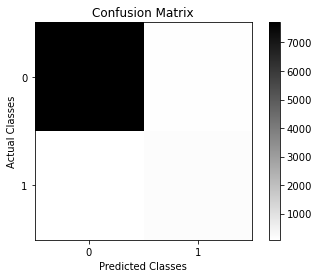

In [ ]:
cm.plot()

### Overall CM Statistics

In [ ]:
cm.stat(summary=True)

Overall Statistics : 

ACC Macro                                                         0.97481
F1 Macro                                                          0.81881
FPR Macro                                                         0.15607
Kappa                                                             0.6377
Overall ACC                                                       0.97481
PPV Macro                                                         0.79741
SOA1(Landis & Koch)                                               Substantial
TPR Macro                                                         0.84393
Zero-one Loss                                                     204

Class Statistics :

Classes                                                           0             1             
ACC(Accuracy)                                                     0.97481       0.97481       
AUC(Area under the ROC curve)                                     0.84393       0.84393       
AUCI(A

In [ ]:
print(cm.overall_stat["F1 Macro"], cm.overall_stat["F1 Micro"])

0.8188107034583427 0.9748148148148148


In [ ]:
for threshold in np.arange(0.94, 0.98, 0.001):
    predict_vector = (similarities > threshold) * 1
    cm = ConfusionMatrix(actual_vector, predict_vector)
    print(threshold, cm.overall_stat["F1 Macro"], cm.overall_stat["F1 Micro"])

0.94 0.7943342347345987 0.9607407407407408
0.941 0.7961175416707023 0.9618518518518518
0.942 0.8002281801581914 0.9633333333333334
0.943 0.804977751750406 0.9648148148148148
0.944 0.80346920761286 0.9649382716049383
0.945 0.8070324396011536 0.9660493827160493
0.946 0.8139888967889743 0.9680246913580247
0.947 0.8173461450204861 0.9691358024691358
0.948 0.8178420436718308 0.9697530864197531
0.949 0.8198551303600636 0.9704938271604938
0.95 0.8183565889351454 0.9708641975308642
0.951 0.8220326427092881 0.9720987654320987
0.952 0.8215783454060237 0.972716049382716
0.953 0.8265895953757225 0.9740740740740741
0.954 0.8267231420870235 0.9745679012345679
0.955 0.8217223174376244 0.9744444444444444
0.956 0.8211626848752959 0.9746913580246913
0.957 0.8188107034583427 0.9748148148148148
0.958 0.8163450853621578 0.9750617283950618
0.959 0.8218237412868286 0.9764197530864197
0.96 0.8199150615423959 0.9769135802469135
0.961 0.8192391542587847 0.9771604938271605
0.962 0.8131372941049815 0.977037037037